### GAIN performance on image type inputs

#### 1. MNIST

Details about each of the architectures used here are explained on the report

In [2]:
# Importing libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm_notebook as tqdm

import torch
import torch.nn.functional as F
import tensorflow as tf
old_v = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from input_data import read_data_sets
# from tensorflow.examples.tutorials.mnist import input_data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
use_gpu = True # set it to True to use GPU and False to use CPU
if use_gpu:
    torch.cuda.set_device(0)

#### System Parameters

Mini batch size: 128    
Missing rate: 0.5   
Hint rate: 0.9    
Loss Hyperparameters: 10  
  
Input dimension (Fixed): 784   
1st Hidden Layer Dim: 256     
2nd Hidden Layer Dim: 128  
Train_No: 55000    
Test_No: 10000    
  
Learning Rate: 0.001    
Epochs: 10000     

In [21]:
# %% Initialize System Parameters
def init_params(mb_size=128, p_miss=0.5, p_hint=0.9, alpha=10, 
                Train_No=55000, Test_No=10000, 
                Dim=784, H_Dim1=256, H_Dim2=128, 
                learning_rate=0.001, epochs=5000): 
    
    # Mini batch size
    mb_size = mb_size
    # Missing rate
    p_miss = p_miss
    # Hint rate
    p_hint = p_hint
    # Loss Hyperparameters
    alpha = alpha
    
    # No
    Train_No = Train_No
    Test_No = Test_No
    
    # Input dimension (Fixed)
    Dim = Dim
    # Hidden state dimensions
    H_Dim1 = H_Dim1
    H_Dim2 = H_Dim2
    
    # Learning Rate
    learning_rate = learning_rate
    # Epochs
    epochs = epochs
    
    return mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs

In [5]:
mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs = init_params()

#### Vanilla GAIN Architecture   

In [6]:
class NetD(torch.nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, h):
        inp = torch.cat((x, h), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
        return out

    
class NetG(torch.nn.Module):
    def __init__(self):
        super(NetG, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, m):
        inp = torch.cat((x, m), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))  # [0,1] Probability Output
        return out

#### GAIN Functions

In [7]:
# Mask Vector and Hint Vector Generation
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size=[m, n])
    B = A > p
    C = 1. * B
    return C


# Random sample generator for Z
def sample_Z(m, n, high):
    return np.random.uniform(0., high, size=[m, n])


# Mini-batch generation
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

In [8]:
def discriminator_loss(netG, netD, M, X, H): 
    # Generator
    G_sample = netG(X, M)
    # Combine with original data
    Hat_New_X = X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H)
    # Loss
    D_loss = -torch.mean(M * torch.log(D_prob + 1e-8) + (1-M) * torch.log(1. - D_prob + 1e-8))
    return D_loss


def generator_loss(netG, netD, X, M, New_X, H):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)
    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H)

    # Loss
    G_loss1 = -torch.mean((1-M) * torch.log(D_prob + 1e-8))
    MSE_train_loss = torch.mean((M * New_X - M * G_sample)**2) / torch.mean(M)
    G_loss = G_loss1 + alpha * MSE_train_loss 

    # MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return G_loss, MSE_train_loss, MSE_test_loss


def test_loss(netG, netD, X, M, New_X):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)

    # MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return MSE_test_loss, G_sample

In [9]:
# Plot (4 x 4 subfigures)
def plot(samples):
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig


def outputFigure(it, netG, Test_No, mb_idx, Dim, high):
    mb_idx = sample_idx(Test_No, 5)
    X_mb = testX[mb_idx, :]
    M_mb = testM[mb_idx, :]
    Z_mb = sample_Z(5, Dim, high)

    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb

    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device='cuda').float()
        M_mb = torch.tensor(M_mb, device='cuda').float()
        New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
        Z_mb = torch.tensor(Z_mb, device='cuda').float()
    else:
        X_mb = torch.tensor(X_mb).float()
        M_mb = torch.tensor(M_mb).float()
        New_X_mb = torch.tensor(New_X_mb).float()
        Z_mb = torch.tensor(Z_mb).float()

    samples1 = X_mb
    samples5 = M_mb * X_mb + (1 - M_mb) * Z_mb
    inp = M_mb * X_mb + (1-M_mb) * New_X_mb
    samples2 = netG(inp, M_mb)
    samples2 = M_mb * X_mb + (1 - M_mb) * samples2

    Z_mb = sample_Z(5, Dim, high)
    if use_gpu is True:
        Z_mb = torch.tensor(Z_mb, device='cuda').float()
    else:
        Z_mb = torch.tensor(Z_mb).float()
    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb

    inp = M_mb * X_mb + (1-M_mb) * New_X_mb
    samples3 = netG(inp, M_mb)
    samples3 = M_mb * X_mb + (1 - M_mb) * samples3

    Z_mb = sample_Z(5, Dim, high)
    if use_gpu is True:
        Z_mb = torch.tensor(Z_mb, device='cuda').float()
    else:
        Z_mb = torch.tensor(Z_mb).float()
    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb
    inp = M_mb * X_mb + (1-M_mb) * New_X_mb
    samples4 = netG(inp, M_mb)
    samples4 = M_mb * X_mb + (1 - M_mb) * samples4

    if use_gpu is True:
        samples = np.vstack([samples5.cpu().detach().data, samples2.cpu().detach().data, 
                             samples3.cpu().detach().data, samples4.cpu().detach().data, 
                             samples1.cpu().detach().data])
    else:
        samples = np.vstack([samples5.detach().data, samples2.detach().data, 
                             samples3.detach().data, samples4.detach().data, 
                             samples1.detach().data])
    fig = plot(samples)
    plt.savefig('imputed/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
    plt.close(fig)

In [22]:
def trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, alpha=alpha, epochs=epochs, 
              high=0.01, printLoss=True, outFigure=True):
    # %% Output Initialization
    if outFigure==True:    
        if not os.path.exists('imputed/'):
            os.makedirs('imputed/')
    
    # %% Start Iterations
    for it in tqdm(range(epochs)):
        # %% Inputs
        mb_idx = sample_idx(Train_No, mb_size) 
        X_mb = trainX[mb_idx,:]  
        Z_mb = sample_Z(mb_size, Dim, high) 

        M_mb = trainM[mb_idx, :]     
        H_mb1 = sample_M(mb_size, Dim, 1-p_hint) 
        H_mb = M_mb * H_mb1  
        # H_mb = M_mb * H_mb1 + 0.5 * (1 - H_mb1)

        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce 

        if use_gpu is True:
            X_mb = torch.tensor(X_mb, device='cuda').float()
            M_mb = torch.tensor(M_mb, device='cuda').float()
            H_mb = torch.tensor(H_mb, device='cuda').float()
            New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
            Z_mb = torch.tensor(Z_mb, device='cuda').float()
        else:
            X_mb = torch.tensor(X_mb).float()
            M_mb = torch.tensor(M_mb).float()
            H_mb = torch.tensor(H_mb).float()
            New_X_mb = torch.tensor(New_X_mb).float()
            Z_mb = torch.tensor(Z_mb).float()

        # Train Discriminator
        optimD.zero_grad() 
        D_loss = discriminator_loss(netG, netD, M=M_mb, X=New_X_mb, H=H_mb)
        D_loss.backward()
        optimD.step()

        # Train Generator
        optimG.zero_grad() 
        G_loss, G_mse_loss, G_mse_test = generator_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb, H=H_mb)
        G_loss.backward()
        optimG.step()
       
        if it % 100 == 0:
            # %% Intermediate Losses
            if printLoss==True:
                print('Iter: {}'.format(it),end='\t')
                print('Train_loss: {:.4}'.format(G_mse_loss),end='\t')
                print('Test_loss: {:.4}'.format(G_mse_test),end='\t')
                print('D_loss: {:.4}'.format(D_loss))
            
            # %% Output figure
            if outFigure==True:
                outputFigure(it, netG, Test_No, mb_idx, Dim, high) 
            

def testGAIN(netG, netD, Dim, testM, testX, high=0.01):
    Z_mb = sample_Z(Test_No, Dim, high) 
    M_mb = testM 
    X_mb = testX
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  

    # make the tensors
    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device='cuda').float()
        M_mb = torch.tensor(M_mb, device='cuda').float()
        New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
    else:
        X_mb = torch.tensor(X_mb).float()
        M_mb = torch.tensor(M_mb).float()
        New_X_mb = torch.tensor(New_X_mb).float()

    MSE_final, Sample = test_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb)
    print('Test RMSE: ' + str(np.sqrt(MSE_final.item())))
    print()
    
    return Sample, New_X_mb

In [11]:
# Plot images before and after Imputation
def plotBeforeAfter(New_X_mb, imputed_x, plot_name1, plot_name2):
    if not os.path.exists('images/'):
        os.makedirs('images/')
    
    # Plot images before Imputation
    fig, axes = plt.subplots(10,10, figsize=(8,8))
    for i,ax in enumerate(axes.flat):
        if use_gpu is True:
            ax.imshow(New_X_mb[i].cpu().reshape(28,28))
        else:
            ax.imshow(New_X_mb[i].reshape(28,28))
    fig.savefig('images/' + plot_name1)
    
    # Plot images after Imputation
    fig, axes = plt.subplots(10,10, figsize=(8,8))
    for i,ax in enumerate(axes.flat):
        if use_gpu is True:
            ax.imshow(imputed_x[i].cpu().detach().numpy().reshape(28,28))
        else:
            ax.imshow(imputed_x[i].detach().numpy().reshape(28,28))
    fig.savefig('images/' + plot_name2)

#### Load Dataset

In [12]:
# mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)
mnist = read_data_sets('./MNIST_data', one_hot = True)
tf.compat.v1.logging.set_verbosity(old_v)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [13]:
# Train / Test Features
trainX, _ = mnist.train.next_batch(Train_No)
testX, _ = mnist.test.next_batch(Test_No)

# Train / Test Missing Indicators
trainM = sample_M(Train_No, Dim, p_miss)
testM = sample_M(Test_No, Dim, p_miss)

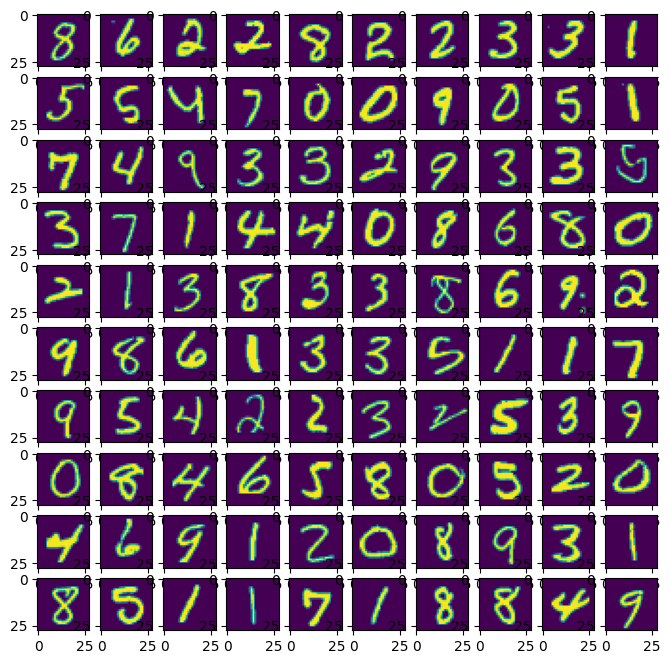

In [14]:
# Plot original images 
fig, axes = plt.subplots(10,10, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(testX[i].reshape(28,28))

if not os.path.exists('images/'):
    os.makedirs('images/')
fig.savefig('images/' + 'original')

#### Training

In [15]:
# %% Init Network 
if use_gpu is True:
    netD = NetD().cuda()
    netG = NetG().cuda()
else:
    netD = NetD()
    netG = NetG()

# Optimizers
optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate)
optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate)

In [16]:
# %% Training
trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, alpha=alpha, epochs=epochs, high=1.)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iter: 0	Train_loss: 0.2336	Test_loss: 0.2336	D_loss: 0.7007
Iter: 100	Train_loss: 0.06227	Test_loss: 0.06173	D_loss: 0.6902
Iter: 200	Train_loss: 0.04557	Test_loss: 0.04866	D_loss: 0.6847
Iter: 300	Train_loss: 0.03352	Test_loss: 0.03839	D_loss: 0.6812
Iter: 400	Train_loss: 0.0339	Test_loss: 0.03938	D_loss: 0.6797
Iter: 500	Train_loss: 0.02801	Test_loss: 0.0348	D_loss: 0.6788
Iter: 600	Train_loss: 0.02789	Test_loss: 0.0346	D_loss: 0.678
Iter: 700	Train_loss: 0.02575	Test_loss: 0.03234	D_loss: 0.6786
Iter: 800	Train_loss: 0.02435	Test_loss: 0.03121	D_loss: 0.6778
Iter: 900	Train_loss: 0.02359	Test_loss: 0.03071	D_loss: 0.6778
Iter: 1000	Train_loss: 0.02275	Test_loss: 0.03044	D_loss: 0.6777
Iter: 1100	Train_loss: 0.02228	Test_loss: 0.03091	D_loss: 0.6773
Iter: 1200	Train_loss: 0.02109	Test_loss: 0.03009	D_loss: 0.6787
Iter: 1300	Train_loss: 0.02011	Test_loss: 0.02836	D_loss: 0.6778
Iter: 1400	Train_loss: 0.01961	Test_loss: 0.02919	D_loss: 0.6777
Iter: 1500	Train_loss: 0.02023	Test_loss: 0

#### Testing

In [17]:
# %% Testing
imputed_x, New_X_mb = testGAIN(netG, netD, Dim, testM, testX, high=1.)

print("Imputed Data Shape:", imputed_x.shape)

Test RMSE: 0.1607284326798233

Imputed Data Shape: torch.Size([10000, 784])


#### Plot images before and after Imputation

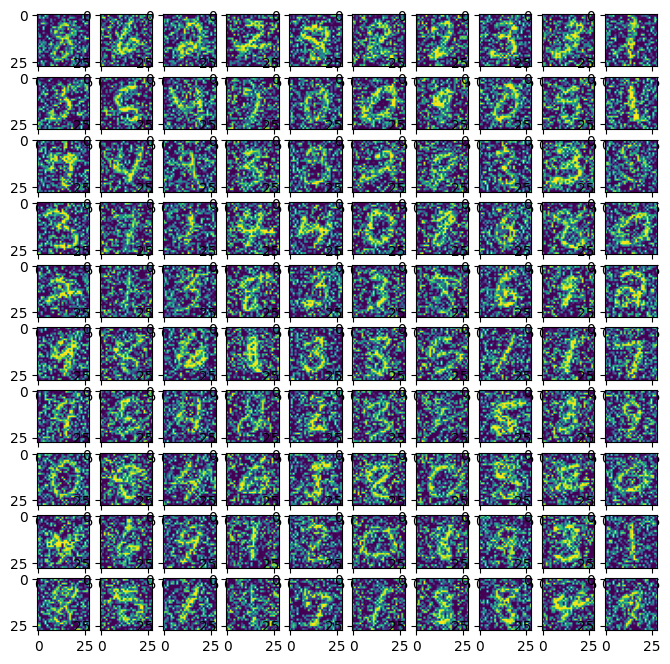

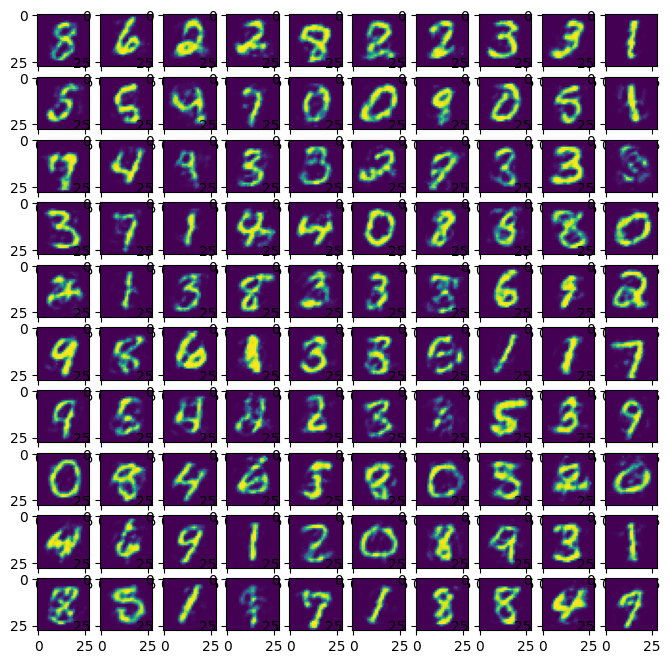

In [18]:
plotBeforeAfter(New_X_mb, imputed_x, 'noise_gain_fast_50.png', 'imputed_gain_fast_50.png')

#### Experiments

#### 1. vanilla GAIN

 #### System Parameters

Mini batch size: 128    
Missing rate: 0.2   
Hint rate: 0.9    
Loss Hyperparameters: 10  
  
Input dimension (Fixed): 784    
1st Hidden Layer Dim: 784      
2nd Hidden Layer Dim: 784   
Train_No: 55000     
Test_No: 10000    
   
Learning Rate: 0.001    
Epochs: 10000    

In [24]:
# System Parameters
mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs = init_params(mb_size=128, p_miss=0.2, p_hint=0.9, alpha=10, 
                                                                                                            Train_No=55000, Test_No=10000, 
                                                                                                            Dim=784, H_Dim1=784, H_Dim2=784, 
                                                                                                            learning_rate=0.001, epochs=5000)

In [25]:
# %% Init Network 
if use_gpu is True:
    netD = NetD().cuda()
    netG = NetG().cuda()
else:
    netD = NetD()
    netG = NetG()

# Optimizers
optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate)
optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate)

In [26]:
trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, alpha=alpha, epochs=epochs, 
          high=0.01, printLoss=False, outFigure=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [27]:
# %% Testing
imputed_x, New_X_mb = testGAIN(netG, netD, Dim, testM, testX)

print("Imputed Data Shape:", imputed_x.shape)

Test RMSE: 0.18365009944639413

Imputed Data Shape: torch.Size([10000, 784])


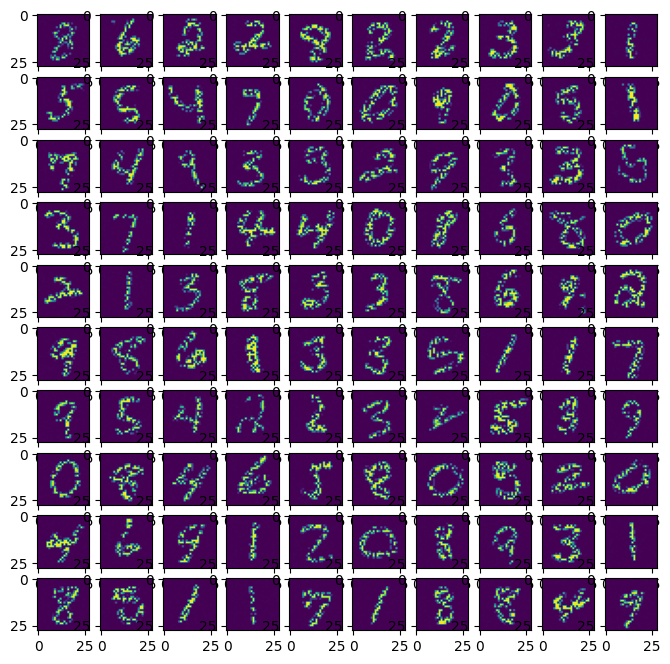

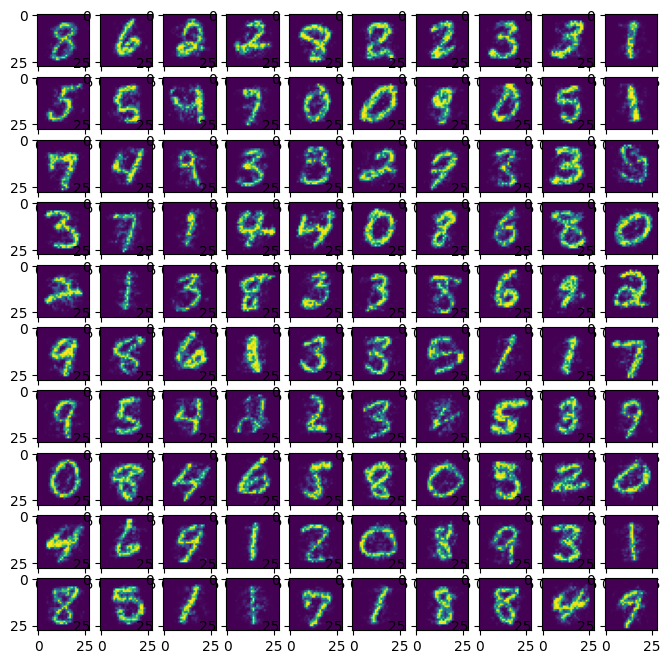

In [28]:
plotBeforeAfter(New_X_mb, imputed_x, 'noise_gain.png', 'imputed_gain.png')

#### 2. GAIN-FAST (Missing Rate: 0.2, sample_Z: high: 0.01)

In [29]:
# System Parameters
mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs = init_params(p_miss=0.2)

In [30]:
# %% Init Network 
if use_gpu is True:
    netD = NetD().cuda()
    netG = NetG().cuda()
else:
    netD = NetD()
    netG = NetG()

# Optimizers
optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate)
optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate)

In [31]:
trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, alpha=alpha, epochs=epochs, 
          high=0.01, printLoss=False, outFigure=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [32]:
# %% Testing
imputed_x, New_X_mb = testGAIN(netG, netD, Dim, testM, testX)

print("Imputed Data Shape:", imputed_x.shape)

Test RMSE: 0.137935915201103

Imputed Data Shape: torch.Size([10000, 784])


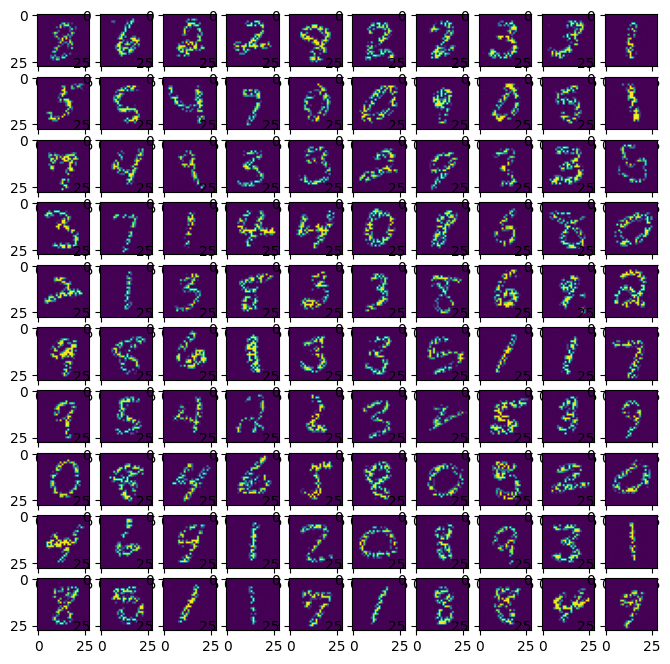

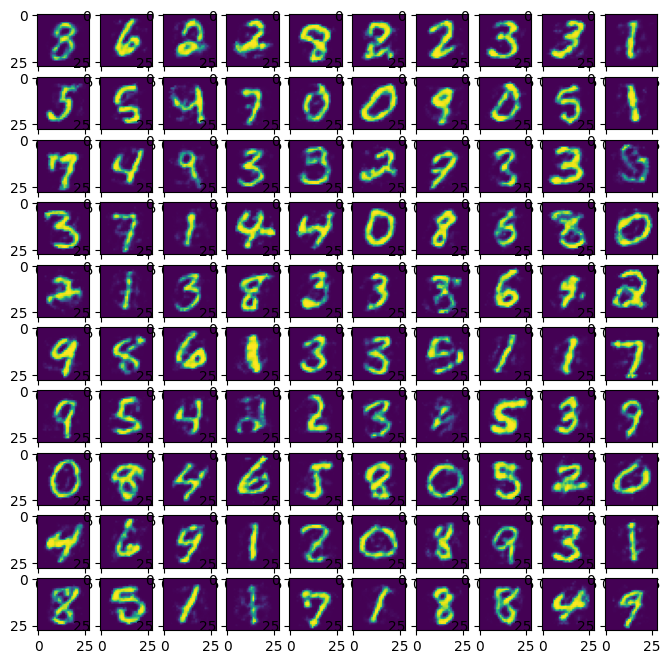

In [33]:
plotBeforeAfter(New_X_mb, imputed_x, 'noise_gain_fast.png', 'imputed_gain_fast.png')

#### 3. GAIN-CNN

In [34]:
# System Parameters
mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs = init_params(p_miss=0.2)

In [35]:
# Defining cnn layers
class encode(torch.nn.Module):
    def __init__(self,in_c):
        super(encode,self).__init__()
        # encoder layers
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = torch.nn.Conv2d(in_c, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = torch.nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = torch.nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = torch.nn.MaxPool2d(2, 2)

    def forward(self,x):
        # encode 
        # add hidden layers with relu activation function and maxpooling after
        x = F.relu(self.conv1(x.float()))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x) # compressed representation
        return x
    

class decode(torch.nn.Module):
    def __init__(self):
        super(decode,self).__init__()
        self.t_conv1 = torch.nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image       
        self.t_conv2 = torch.nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = torch.nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = torch.nn.Conv2d(32, 1, 3, padding=1)
        
    def forward(self,x):
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = torch.sigmoid(self.conv_out(x))        
        return x.reshape(-1, 28, 28).flatten(start_dim=1, end_dim=-1)

In [36]:
class NetDCNN(torch.nn.Module):
    def __init__(self):
        super(NetDCNN, self).__init__()
        # ADD CNN LAYERS 
        # encode-decode
        self.encode = encode(2)
        self.decode = decode()
        self.net = torch.nn.Sequential(self.encode, self.decode)
        # keep as they are
        self.fc3 = torch.nn.Linear(Dim, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()
    
    def init_weight(self):
        layers = [self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]
        
    def forward(self, x, h):
        inp, h = x.reshape(-1, 1, 28, 28), h.reshape(-1, 1, 28, 28)
        inp = torch.cat((inp, h), dim=1)
        # cnn-encode-decode
        out = self.net(inp)
        out = self.sigmoid(self.fc3(out))
        return out    

    
class NetGCNN(torch.nn.Module):
    def __init__(self):
        super(NetGCNN, self).__init__()
        # ADD CNN LAYERS 
        # encode-decode
        self.encode = encode(2)
        self.decode = decode()
        self.net = torch.nn.Sequential(self.encode, self.decode)
        # keep as they are 
        self.fc3 = torch.nn.Linear(Dim, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid() # [0,1] Probability Output
        self.init_weight()
    
    def init_weight(self):
        layers = [self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]
        
    def forward(self, x, m):
        inp, m = x.reshape(-1, 1, 28, 28), m.reshape(-1, 1, 28, 28)
        inp = torch.cat((inp, m), dim=1)
        # Cnn Layers forward 
        out = self.net(inp)
        # keep as it is 
        out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
        return out     

In [37]:
# %% Init Network 
if use_gpu is True:
    netDCNN = NetDCNN().cuda()
    netGCNN = NetGCNN().cuda()
else:
    netDCNN = NetDCNN()
    netGCNN = NetGCNN()

# Optimizers
optimDCNN = torch.optim.Adam(netDCNN.parameters(), lr=learning_rate)
optimGCNN = torch.optim.Adam(netGCNN.parameters(), lr=learning_rate)

In [38]:
trainGAIN(netGCNN, netDCNN, Dim, trainX, trainM, optimGCNN, optimDCNN, alpha=alpha, epochs=epochs, 
          high=0.01, printLoss=False, outFigure=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [39]:
# %% Testing
imputed_x, New_X_mb = testGAIN(netGCNN, netDCNN, Dim, testM, testX)

print("Imputed Data Shape:", imputed_x.shape)

Test RMSE: 0.12897236169084217

Imputed Data Shape: torch.Size([10000, 784])


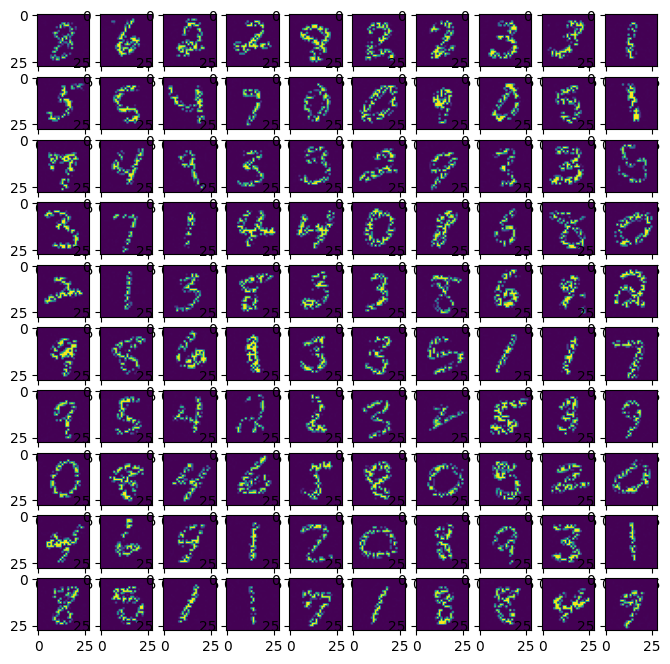

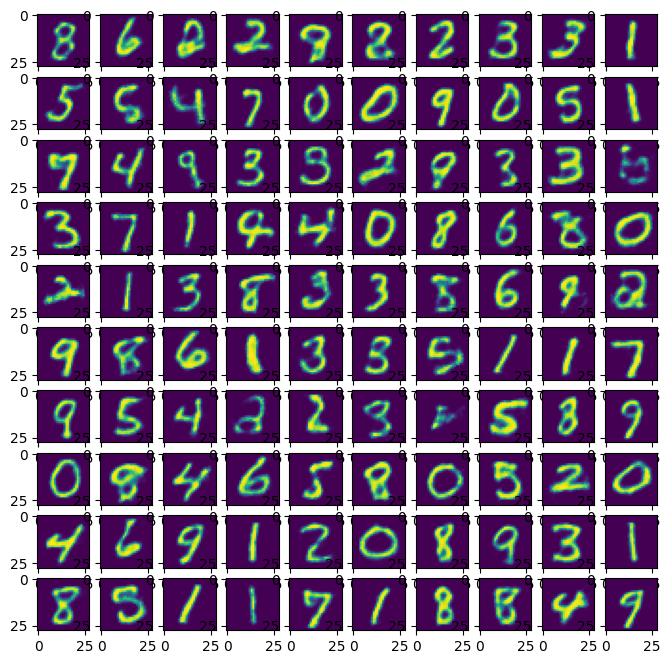

In [40]:
plotBeforeAfter(New_X_mb, imputed_x, 'noise_gain_cnn.png', 'imputed_gain_cnn.png')

#### 4. GAIN-DEEP (adding 2 more hidden layers to the original architecture)

In [41]:
mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs = init_params(p_miss=0.2, Dim=784, H_Dim1=784, H_Dim2=784)

In [42]:
class NetD_deep(torch.nn.Module):
    def __init__(self):
        super(NetD_deep, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim1)
        self.fc3 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc4 = torch.nn.Linear(H_Dim2, H_Dim2)
        self.fc5 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, h):
        inp = torch.cat((x, h), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out = self.sigmoid(self.fc5(out)) # [0,1] Probability Output
        return out

    
class NetG_deep(torch.nn.Module):
    def __init__(self):
        super(NetG_deep, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim1)
        self.fc3 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc4 = torch.nn.Linear(H_Dim2, H_Dim2)
        self.fc5 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, m):
        inp = torch.cat((x, m), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out = self.sigmoid(self.fc5(out))  # [0,1] Probability Output
        return out

In [43]:
# %% Init Network 
if use_gpu is True:
    netD_deep = NetD_deep().cuda()
    netG_deep = NetG_deep().cuda()
else:
    netD_deep = NetD_deep()
    netG_deep = NetG_deep()

# Optimizers
optim_netD_deep = torch.optim.Adam(netD_deep.parameters(), lr=learning_rate)
optim_netG_deep = torch.optim.Adam(netG_deep.parameters(), lr=learning_rate)

In [44]:
trainGAIN(netG_deep, netD_deep, Dim, trainX, trainM, optim_netG_deep, optim_netD_deep, alpha=alpha, epochs=epochs, 
          high=0.01, printLoss=False, outFigure=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [45]:
# %% Testing
imputed_x, New_X_mb = testGAIN(netG_deep, netD_deep, Dim, testM, testX)

print("Imputed Data Shape:", imputed_x.shape)

Test RMSE: 0.11958961230736428

Imputed Data Shape: torch.Size([10000, 784])


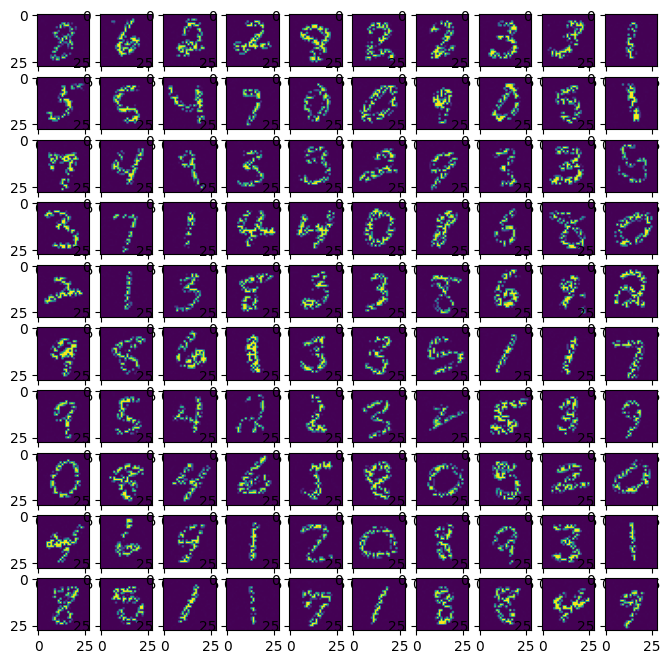

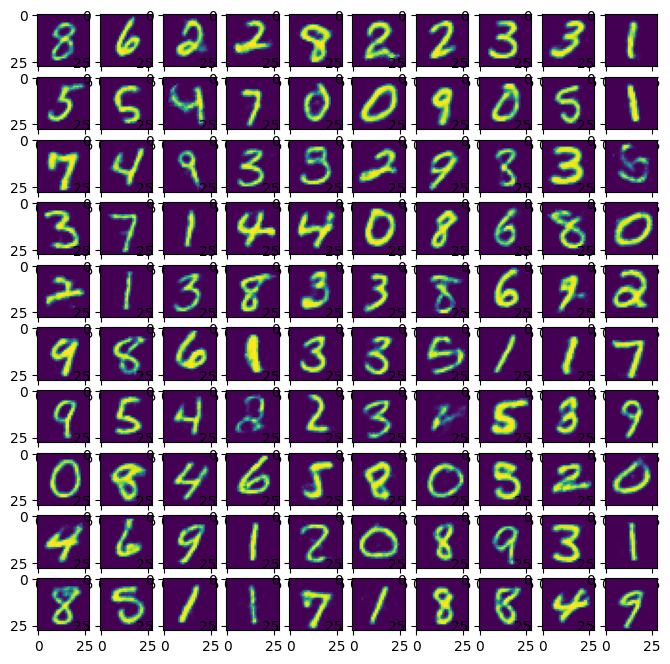

In [46]:
plotBeforeAfter(New_X_mb, imputed_x, 'noise_gain_deep.png', 'imputed_gain_deep.png')

#### GAIN-V2

In [47]:
mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs = init_params(mb_size=64, 
                                                                                                            p_miss=0.2, 
                                                                                                            Dim=784, 
                                                                                                            H_Dim1=784, 
                                                                                                            H_Dim2=784//2)

In [48]:
class NetD_td(torch.nn.Module):
    def __init__(self):
        super(NetD_td, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1) # with Hint
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, H_Dim1)
        self.fc4 = torch.nn.Linear(H_Dim1, Dim)
        
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3, self.fc4]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, h):
        inp = torch.cat((x, h), dim=1)
        out = self.tanh(self.fc1(inp))
        out = self.tanh(self.fc2(out))
        out = self.tanh(self.fc3(out))
        out = self.sigmoid(self.fc4(out)) # [0,1] Probability Output
        return out

    
class NetG_td(torch.nn.Module):
    def __init__(self):
        super(NetG_td, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1) # with Hint
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, H_Dim1)
        self.fc4 = torch.nn.Linear(H_Dim1, Dim)
        
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3, self.fc4]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, m):
        inp = torch.cat((x, m), dim=1)
        out = self.tanh(self.fc1(inp))
        out = self.tanh(self.fc2(out))
        out = self.tanh(self.fc3(out))
        out = self.sigmoid(self.fc4(out))  # [0,1] Probability Output
        return out

In [49]:
# %% Init Network 
if use_gpu is True:
    netD_td = NetD_td().cuda()
    netG_td = NetG_td().cuda()
else:
    netD_td = NetD_td()
    netG_td = NetG_td()

# Optimizers
optim_netD_td = torch.optim.Adam(netD_td.parameters(), lr=learning_rate)
optim_netG_td = torch.optim.Adam(netG_td.parameters(), lr=learning_rate)

In [50]:
trainGAIN(netG_td, netD_td, Dim, trainX, trainM, optim_netG_td, optim_netD_td, alpha=alpha, epochs=epochs, 
          high=0.01, printLoss=False, outFigure=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [51]:
# %% Testing
imputed_x, New_X_mb = testGAIN(netG_td, netD_td, Dim, testM, testX)

print("Imputed Data Shape:", imputed_x.shape)

Test RMSE: 0.12683634889216974

Imputed Data Shape: torch.Size([10000, 784])


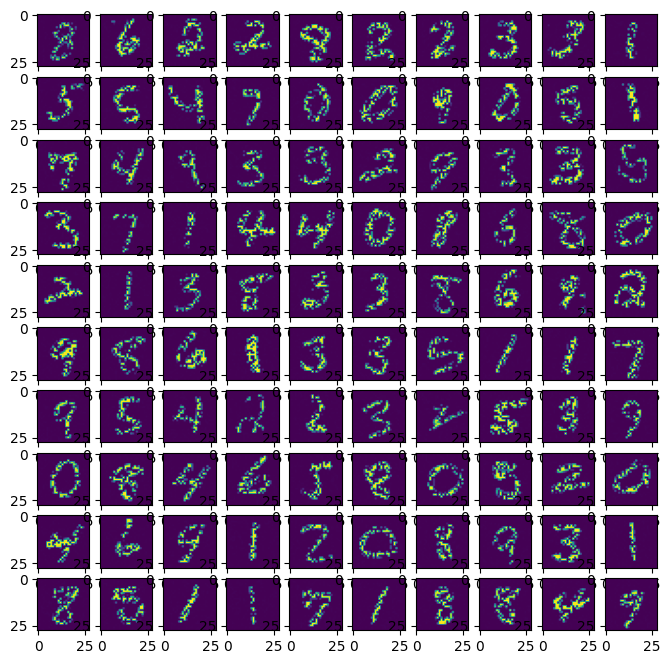

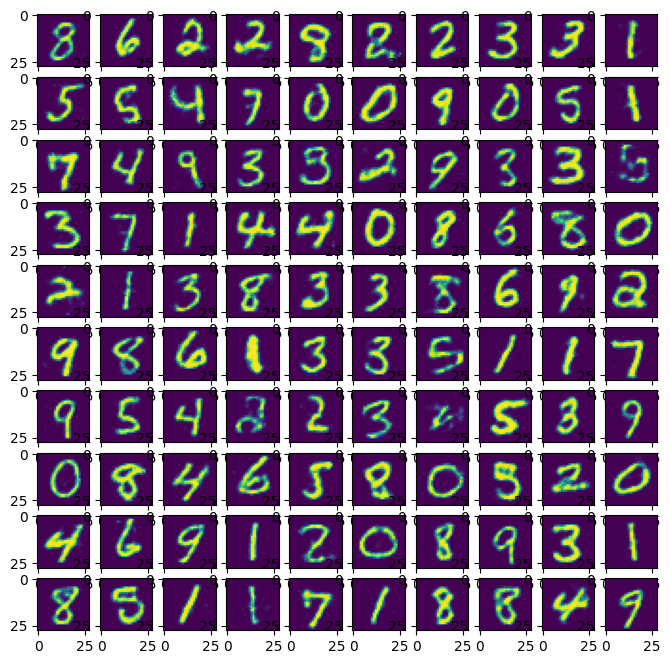

In [52]:
plotBeforeAfter(New_X_mb, imputed_x, 'noise_gain_v2.png', 'imputed_gain_v2.png')

In [66]:
!zip -r /content/file1.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/noise_gain_fast.png (deflated 1%)
  adding: content/images/noise_gain_fast_50.png (deflated 0%)
  adding: content/images/imputed_gain_fast.png (deflated 1%)
  adding: content/images/imputed_gain_cnn.png (deflated 1%)
  adding: content/images/noise_gain.png (deflated 1%)
  adding: content/images/imputed_gain.png (deflated 1%)
  adding: content/images/noise_gain_v2.png (deflated 1%)
  adding: content/images/imputed_gain_deep.png (deflated 1%)
  adding: content/images/noise_gain_deep.png (deflated 1%)
  adding: content/images/imputed_gain_v2.png (deflated 1%)
  adding: content/images/imputed_gain_fast_50.png (deflated 1%)
  adding: content/images/original.png (deflated 1%)
  adding: content/images/noise_gain_cnn.png (deflated 1%)


In [67]:
from google.colab import files
files.download("/content/file1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>